* In this notebook we will try to classify observations of Sleep stages to be either W, NREM and REM. 
* I will try to have a complete cycle of the data science workflow including querying the database to get the dataset, data analysis and building machine learning models to predict for new data.
* For this analysis I am using a sample data from Kaggle.

Real Data Information:
1. The data has been captured from **patients of different age group**.
1. A flagship project at **ETH Zurich and the University of Zurich** named, SleepLoop.
1. The **data has been collected from hospitals and test centers** collaborated with ETH Zurich and the University of Zurich and Ulm University.
1. Fewer students get the chance to work o the project. Luckily, I was the person who get the chance to work on it closely.
1. The **data was collected from the sensors** attached on the face and heads: to record **EEG, EOG, and EMG **signals.

**EEG**: An electroencephalogram (EEG) is a procedure that measures electrical activity produced by the brain, placing several small metal plates on the scalp. IT is a electrical impulses, which are constantly active even while a person is asleep as evidenced by peaks in the sleep wave.
**EOG**: It measures the corneo-retinal standing potential that lies between the front and the back of the human eye.
**EMG**: It is a method to evaluate the condition of the muscles

Key Features of the Dataset Used for reference:
1. Comprehensive Sleep Metrics: Explore **sleep duration, quality**, and **factors influencing sleep patterns**.
1. Lifestyle Factors: Analyze **physical activity levels, stress levels, and BMI categories**.
1. Cardiovascular Health: Examine **blood pressure and heart rate** measurements.
1. Sleep Disorder Analysis: Identify the occurrence of **sleep disorders such as Insomnia and Sleep Apnea** i.e. (Wake, REM and NREM sleep stages).

Model Used: 
**XGBoost**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px


from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [3]:
#Load the dataset
sleepdata = pd.read_csv('/kaggle/input/sleep-health-and-lifestyle-dataset/Sleep_health_and_lifestyle_dataset.csv')

In [4]:
sleepdata.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
sleepdata.shape

(374, 13)

In [6]:
# for the given coloumns of the dataset: # Renaming columns to lowercase and replacing spaces with underscores
sleepdata.columns = [i.lower().replace(' ', '_') for i in sleepdata.columns]

In [7]:
sleepdata.head()

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [8]:
#we can remove the person's Id from given index
sleepdata.drop(columns='person_id',inplace=True)

In [9]:
sleepdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender                   374 non-null    object 
 1   age                      374 non-null    int64  
 2   occupation               374 non-null    object 
 3   sleep_duration           374 non-null    float64
 4   quality_of_sleep         374 non-null    int64  
 5   physical_activity_level  374 non-null    int64  
 6   stress_level             374 non-null    int64  
 7   bmi_category             374 non-null    object 
 8   blood_pressure           374 non-null    object 
 9   heart_rate               374 non-null    int64  
 10  daily_steps              374 non-null    int64  
 11  sleep_disorder           155 non-null    object 
dtypes: float64(1), int64(6), object(5)
memory usage: 35.2+ KB


From the given info:
1. **Customer Demographic Data**: Gender, Age, Occupation
1. **Sleep Data**: Sleep, Duration, Quality of sleep, Sleep disorder (sleep stages: W, REM, NREM)
1. **Health Related Data**: Physical activity level, BMI category, Blood Pressure, Heart Rate, Daily steps

In [10]:
# Find the null value in the dataset
sleepdata.isna().sum()

gender                       0
age                          0
occupation                   0
sleep_duration               0
quality_of_sleep             0
physical_activity_level      0
stress_level                 0
bmi_category                 0
blood_pressure               0
heart_rate                   0
daily_steps                  0
sleep_disorder             219
dtype: int64

In [11]:
sleepdata.blood_pressure.unique()

array(['126/83', '125/80', '140/90', '120/80', '132/87', '130/86',
       '117/76', '118/76', '128/85', '131/86', '128/84', '115/75',
       '135/88', '129/84', '130/85', '115/78', '119/77', '121/79',
       '125/82', '135/90', '122/80', '142/92', '140/95', '139/91',
       '118/75'], dtype=object)

In [12]:
# Splitting the blood pressure into two columns so it can be processed and visualized easier
sleepdata[['systolic', 'diastolic']
           ] = sleepdata.blood_pressure.str.split('/', expand=True)

sleepdata['systolic'] = sleepdata['systolic'].astype('int')
sleepdata['diastolic'] = sleepdata['diastolic'].astype('int')
sleepdata.drop('blood_pressure', axis=1, inplace=True)

# EDA( Exploratory Data Analysis )

***Gender Analysis***

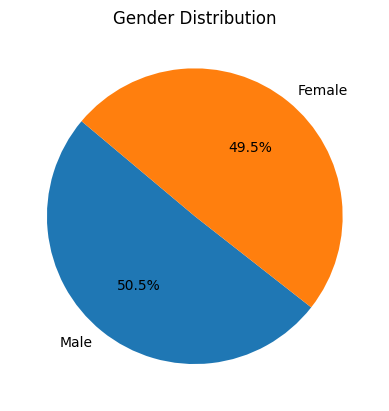

In [13]:
plt.pie(sleepdata['gender'].value_counts().values,
        labels=sleepdata['gender'].value_counts().index, autopct='%1.1f%%', startangle=140)

plt.title('Gender Distribution')
plt.show()

***Blood_pressure VS GenderVS number of patients***

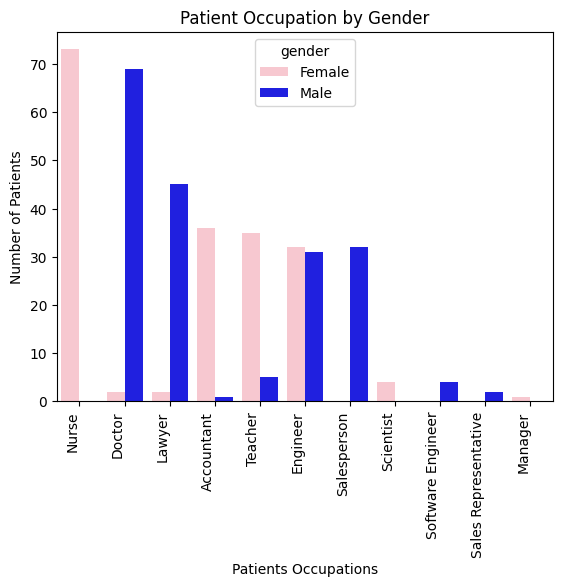

In [14]:
# Grouping The occupation column by gender to see if some occupations are dominated by either gender
gender_by_occupation = sleepdata.groupby(
    ['occupation', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'pink'}

# Sort the data by count
gender_by_occupation = gender_by_occupation.sort_values(
    by='count', ascending=False)


# Plot the data
sns.barplot(y='count', x='occupation', hue='gender', data=gender_by_occupation,
            palette=gender_colors, width=0.8)

# Set the title and axis labels
plt.title('Patient Occupation by Gender')
plt.xlabel('Patients Occupations')
plt.ylabel('Number of Patients')

plt.xticks(rotation=90, ha='right')


# Show the plot
plt.show()

BMI VS GenderVS number of patients

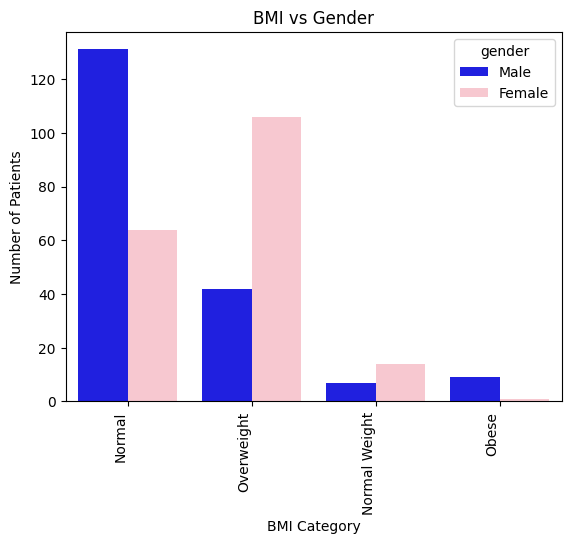

In [15]:
# Grouping the BMI Category by Gender
gender_by_bmi = sleepdata.groupby(
    ['bmi_category', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'pink'}

# Sort the data by count
gender_by_bmi = gender_by_bmi.sort_values(
    by='count', ascending=False)


# Plot the data
sns.barplot(y='count', x='bmi_category', hue='gender', data=gender_by_bmi,
            palette=gender_colors, width=0.8)

# Set the title and axis labels
plt.title('BMI vs Gender')
plt.xlabel('BMI Category')
plt.ylabel('Number of Patients')

plt.xticks(rotation=90, ha='right')


# Show the plot
plt.show()

Sleeping Hours VS GenderVS number of patients

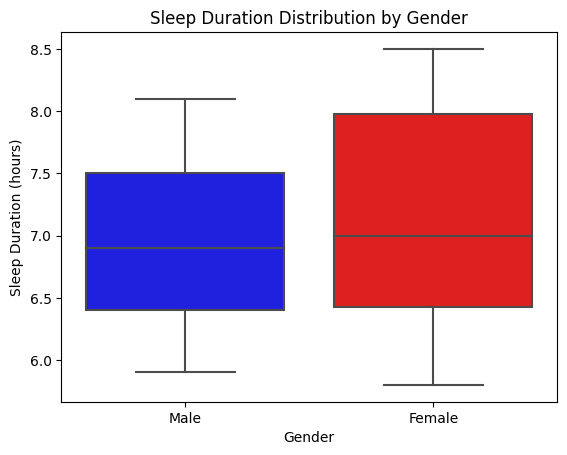

In [16]:
# Grouping the sleep duration column by the gender
sleep_duration_by_gender = sleepdata.groupby(
    ['sleep_duration', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'red'}

# Sort the data by count
sleep_duration_by_gender = sleep_duration_by_gender.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='sleep_duration', x='gender', data=sleep_duration_by_gender,
            palette=gender_colors,)

# Set the title and axis labels
plt.title('Sleep Duration Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Sleep Duration (hours)')

# Show the plot
plt.show()

Quality of sleep VS Gender

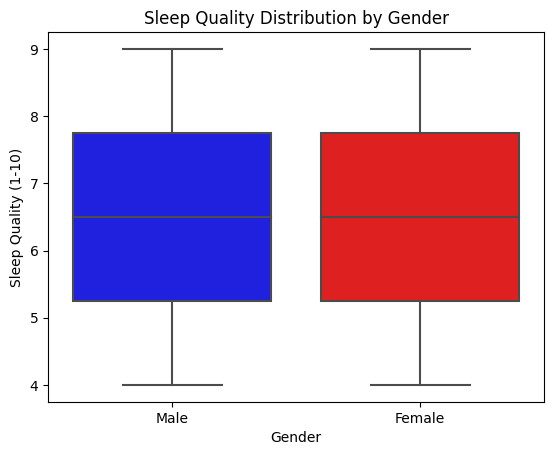

In [17]:
# Grouping the quality of sleep column by gender
sleep_quality_by_gender = sleepdata.groupby(
    ['quality_of_sleep', 'gender']).size().reset_index(name='count')

gender_colors = {'Male': 'blue', 'Female': 'red'}

# Sort the data by count
sleep_quality_by_gender = sleep_quality_by_gender.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='quality_of_sleep', x='gender', data=sleep_quality_by_gender,
            palette=gender_colors,)

# Set the title and axis labels
plt.title('Sleep Quality Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Sleep Quality (1-10)')

# Show the plot
plt.show()

Main Conclusions

The dataset exhibits a nearly equal distribution of gender, with approximately half of the observations belonging to males and the other half to females.

In the dataset, a significant number of occupations display gender dominance, wherein one gender constitutes a substantially higher proportion within specific professions.

An interesting finding within the dataset reveals a notable disparity between genders concerning weight issues. Females are observed to be considerably more susceptible to weight-related problems compared to males.

The dataset's analysis also highlights variations in sleep duration between genders. On average, females tend to have a longer duration of sleep compared to their males.

There is a similarity in the reported sleep quality between males and females, with both genders typically rating their sleep quality within the range of 6 to 8 on a scale of 1 to 10.

Based on the Occupation

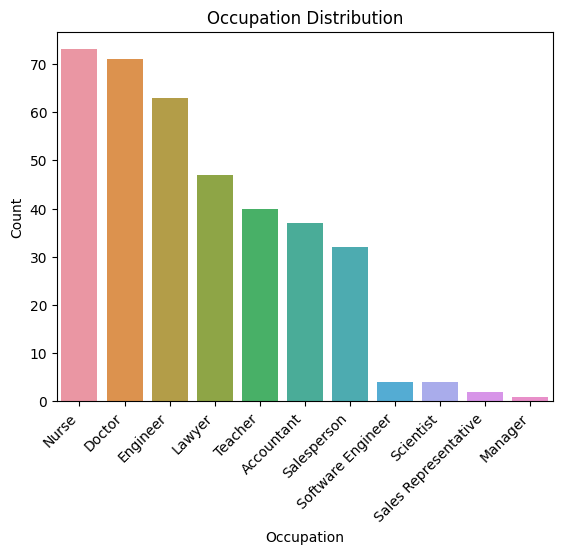

In [18]:
# Sorting the occupations by number of people who belong to them
occupation_counts = sleepdata['occupation'].value_counts(
).sort_values(ascending=False)


sns.barplot(x=occupation_counts.index, y=occupation_counts.values)

# Setting titles
plt.title('Occupation Distribution')
plt.xlabel('Occupation')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')

plt.show()

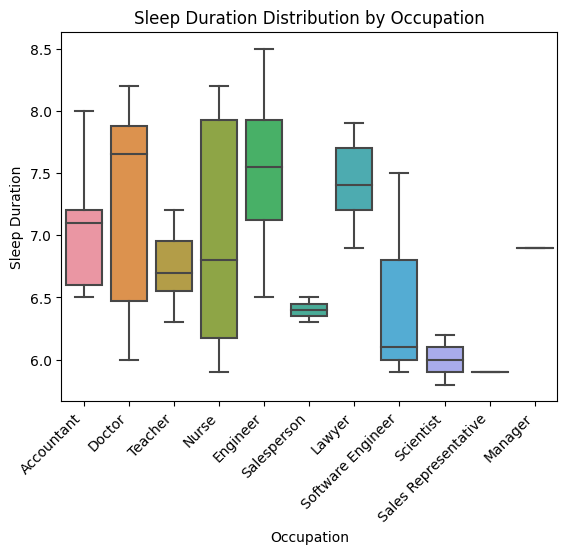

In [19]:
# Grouping the sleep duration column by the occupation
sleep_duration_by_occupation = sleepdata.groupby(
    ['sleep_duration', 'occupation']).size().reset_index(name='count')


# Sort the data by count
sleep_duration_by_occupation = sleep_duration_by_occupation.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='sleep_duration', x='occupation',
            data=sleep_duration_by_occupation)

# Set the title and axis labels
plt.title('Sleep Duration Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Duration')


plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

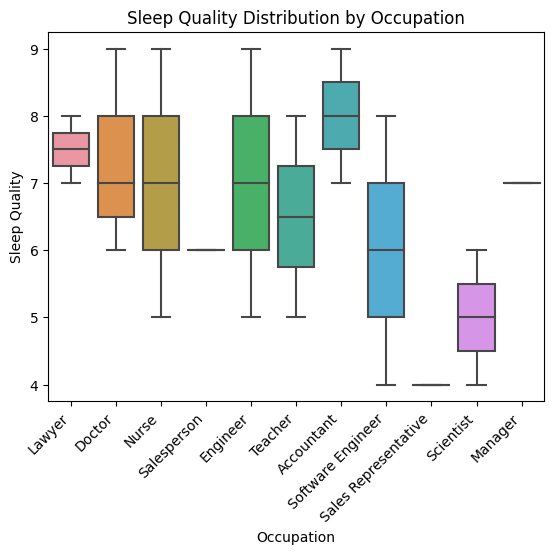

In [20]:
# Grouping the quality of sleep column by the occupation
sleep_quality_by_occupation = sleepdata.groupby(
    ['quality_of_sleep', 'occupation']).size().reset_index(name='count')


# Sort the data by count
sleep_quality_by_occupation = sleep_quality_by_occupation.sort_values(
    by='count', ascending=False)


# Plot the data
sns.boxplot(y='quality_of_sleep', x='occupation',
            data=sleep_quality_by_occupation)

# Set the title and axis labels
plt.title('Sleep Quality Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Sleep Quality')


plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


Main Conclusions

The dataset reveals substantial variations in sleep durations among different occupations. Salespersons, teachers, nurses and accountants tend to report the lowest sleep durations, while lawyers, engineers, and doctors report the longest sleep durations. Among doctors and nurses, there is considerable variation, with doctors reporting the most sleep and nurses having significantly less sleep.

In terms of sleep quality, as measured on a scale of 1 to 10, the majority of occupations reported comparable values, with a predominant concentration falling between 6 and 8. However, notable differences can be observed within specific professions. Accountants and lawyers tend to have higher reported sleep quality, while salespersons and teachers reported lower sleep quality scores.

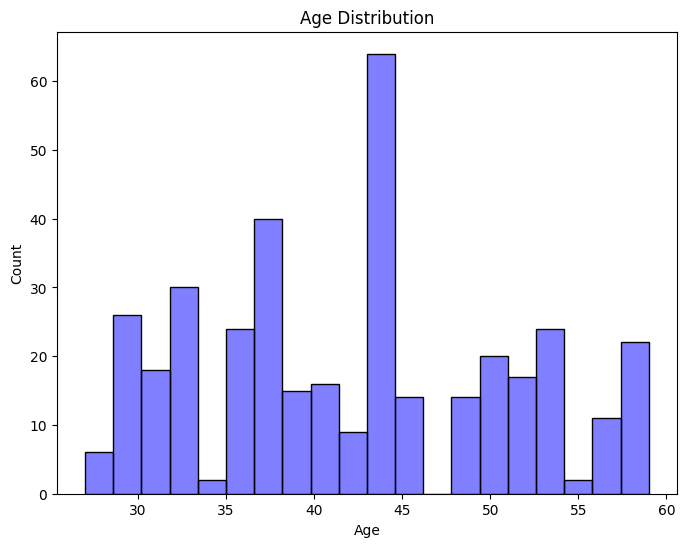

In [21]:
# Plotting the Age Distrubution in the dataset
plt.figure(figsize=(8, 6))

sns.histplot(data=sleepdata['age'], bins=20,
             color='blue', alpha=0.5)

plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

plt.show()

Based on Sleep Disorder and Quality of Sleep

In [22]:
# Plotting a box plot for the relationship between the Sleep Disorder and Physical Activity Level
fig = px.box(sleepdata, x="sleep_disorder", y="physical_activity_level",
             title="Box plot of Physical Activity Level")

fig.update_layout(
    xaxis_title="Sleep Disorder",
    yaxis_title="Physical Activity Level",
)

fig.show()

In [23]:
# Two categorical variables plotted against each other
# Plotting a box plot for the relationship between the Sleep Disorder and BMI Category
fig = px.violin(sleepdata, x="sleep_disorder", y="bmi_category",
             title="Box plot of BMI Category")

fig.update_layout(
    xaxis_title="BMI Category",
    yaxis_title="Sleep Disorder",
)

fig.show()

In [24]:
# Plotting a box plot for the relationship between the Quality of Sleep and Physical Activity Level
fig = px.box(sleepdata, x="quality_of_sleep", y="physical_activity_level",
             title="Box plot of Physical Activity Level")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Physical Activity Level",
)

fig.show()

In [25]:
# Plotting a box plot for the relationship between the Sleep Disorder, Sleep Disorder, and Physical Activity Level
fig = px.box(sleepdata, x="quality_of_sleep", y="physical_activity_level", color='sleep_disorder',
             title="Box plot of Physical Activity Level")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Physical Activity Level (minutes/day)",
)

fig.show()

In [26]:
# Plotting a box plot for the relationship between the Sleep Disorder and Stress Level
fig = px.box(sleepdata, x="quality_of_sleep", y="stress_level",
             title="Box plot of Stress Level")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Stress Level (1-10)",
)

fig.show()

In [27]:
# Plotting a box plot for the relationship between the Quality of SLeep and BMI Category
fig = px.box(sleepdata, x="bmi_category", y="quality_of_sleep",
             title="Box plot of BMI Category")

fig.update_layout(
    xaxis_title="BMI Category",
    yaxis_title="Quality of Sleep",
)

fig.show()

In [28]:
# Plotting a box plot for the relationship between the Quality of SLeep and Age
fig = px.box(sleepdata, x="quality_of_sleep", y="age",
             title="Box plot Age")

fig.update_layout(
    xaxis_title="Quality of Sleep",
    yaxis_title="Age",
)

fig.show()

In [29]:
# A heatmap represeting the correlation between the numerical variables in the dataset
corr = px.imshow(sleepdata.corr(numeric_only=True),)
corr.show()

In [30]:
sleepdata.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,NaN,126,83
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,NaN,125,80
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,140,90


In [31]:
le = LabelEncoder()
sleepdata['gender'] = le.fit_transform(sleepdata['gender'])
sleepdata['occupation'] = le.fit_transform(sleepdata['occupation'])
sleepdata['bmi_category'] = le.fit_transform(sleepdata['bmi_category'])
sleepdata['sleep_disorder'] = le.fit_transform(sleepdata['sleep_disorder'])

In [32]:
sleepdata.head()

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,heart_rate,daily_steps,sleep_disorder,systolic,diastolic
0,1,27,9,6.1,6,42,6,3,77,4200,2,126,83
1,1,28,1,6.2,6,60,8,0,75,10000,2,125,80
2,1,28,1,6.2,6,60,8,0,75,10000,2,125,80
3,1,28,6,5.9,4,30,8,2,85,3000,1,140,90
4,1,28,6,5.9,4,30,8,2,85,3000,1,140,90


In [33]:
# The columns to remove outliers from
num_col = ['age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level', 'stress_level',
           'heart_rate', 'daily_steps', 'diastolic', 'systolic']

# Computing IQR
Q1 = sleepdata[num_col].quantile(0.25)
Q3 = sleepdata[num_col].quantile(0.75)
IQR = Q3 - Q1

# Removing outliers
sleepdata = sleepdata[~((sleepdata[num_col] < (Q1 - 1.5 * IQR)) |
                          (sleepdata[num_col] > (Q3 + 1.5 * IQR))).any(axis=1)]

Creating Training and Testing Sets

In [34]:
X = sleepdata.drop(['sleep_disorder'], axis=1)
y = sleepdata['sleep_disorder']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Creating and Evaluating the models

In [37]:
model_list = [
    ('LogReg', LogisticRegression()),
    ('XGB', XGBClassifier())
]

results_scaled = []
names_of_models = []

for name, model in model_list:
    kfold = KFold(n_splits=5, random_state=7, shuffle=True)
    cv_results = cross_val_score(
        model, X_train_scaled, y_train, cv=kfold, scoring='accuracy')
    results_scaled.append(cv_results)
    names_of_models.append(name)
df_results_scaled = pd.DataFrame(results_scaled, index=names_of_models)
df_results_scaled = df_results_scaled.transpose()

df_results_scaled

,LogReg,XGB
0,0.913793,0.913793
1,0.948276,0.948276
2,0.929825,0.929825
3,0.877193,0.877193
4,0.912281,0.894737


In [38]:
df_results_scaled.mean()

LogReg    0.916273
XGB       0.912765
dtype: float64

1. Logistic Regression

In [39]:
log_reg_model = LogisticRegression().fit(X_train_scaled,y_train)

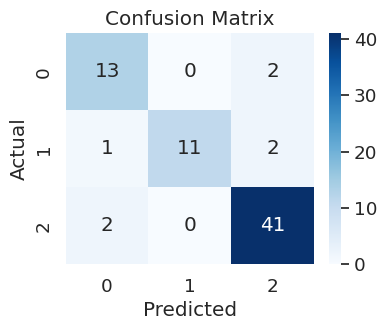

In [40]:
# Getting the predictions for the test set
pred = log_reg_model.predict(X_test_scaled)

# Creating the confusion matrix
c = confusion_matrix(y_test, pred)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)  # Adjust font size for labels
sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [41]:
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, pred)))

print('Micro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='micro')))
print(
    'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='macro')))
print(
    'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='weighted')))
print(
    'Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred, target_names=[
      'Insomnia', 'None', 'Sleep Apnea']))


Accuracy: 0.9028

Micro Precision: 0.90
Micro Recall: 0.90
Micro F1-score: 0.90

Macro Precision: 0.91
Macro Recall: 0.87
Macro F1-score: 0.88

Weighted Precision: 0.91
Weighted Recall: 0.90
Weighted F1-score: 0.90

Classification Report

              precision    recall  f1-score   support

    Insomnia       0.81      0.87      0.84        15
        None       1.00      0.79      0.88        14
 Sleep Apnea       0.91      0.95      0.93        43

    accuracy                           0.90        72
   macro avg       0.91      0.87      0.88        72
weighted avg       0.91      0.90      0.90        72



2. XGBoost

In [42]:
xgb_model = XGBClassifier().fit(X_train_scaled,y_train)

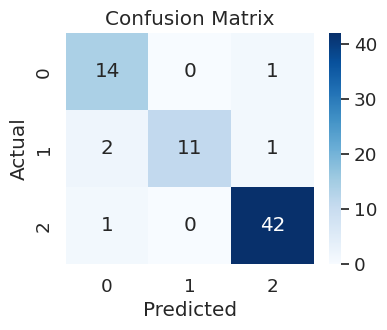

In [43]:
# Getting the predictions for the test set
pred = xgb_model.predict(X_test_scaled)

# Creating the confusion matrix
c = confusion_matrix(y_test, pred)

# Plotting the confusion matrix
plt.figure(figsize=(4, 3))
sns.set(font_scale=1.2)  # Adjust font size for labels
sns.heatmap(c, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, pred)))

print('Micro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='micro')))
print('Micro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='micro')))
print(
    'Micro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='micro')))

print('Macro Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='macro')))
print('Macro Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='macro')))
print(
    'Macro F1-score: {:.2f}\n'.format(f1_score(y_test, pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(
    precision_score(y_test, pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(
    recall_score(y_test, pred, average='weighted')))
print(
    'Weighted F1-score: {:.2f}'.format(f1_score(y_test, pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, pred, target_names=[
      'Insomnia', 'None', 'Sleep Apnea']))


Accuracy: 0.9306

Micro Precision: 0.93
Micro Recall: 0.93
Micro F1-score: 0.93

Macro Precision: 0.93
Macro Recall: 0.90
Macro F1-score: 0.91

Weighted Precision: 0.94
Weighted Recall: 0.93
Weighted F1-score: 0.93

Classification Report

              precision    recall  f1-score   support

    Insomnia       0.82      0.93      0.87        15
        None       1.00      0.79      0.88        14
 Sleep Apnea       0.95      0.98      0.97        43

    accuracy                           0.93        72
   macro avg       0.93      0.90      0.91        72
weighted avg       0.94      0.93      0.93        72



6. Results and Conclusion
* Logistic Regression had an accuracy of 0.90 and a weighted f1 score of 0.90
* XGBoost had an accuracy of 0.93 and a weighted f1 score of 0.93

In our data exploration and analysis we assumed that the BMI Category was a strong indicator of the existance of a sleep disorder, our most reliable model XGBoost also showed that the BMI Category was the most important feature in predicting the existance of a sleep disorder.